# Developing Features

In [39]:
import numpy as np
import pandas as pd
import pyspark
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pyspark.ml import Pipeline # pipeline to transform data
from pyspark.sql import SparkSession # to initiate spark
from pyspark.ml.linalg import Vectors # to allow us to work with VectorAssembler
from pyspark.ml.feature import VectorAssembler # to combine our feature columns to pass to LogisticRegression model
from pyspark.sql.types import FloatType
from pyspark.ml.feature import RegexTokenizer # tokenizer
from pyspark.ml.feature import HashingTF, IDF, IDFModel # vectorizer
from pyspark.ml.feature import StopWordsRemover # to remove stop words
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel # ml model
from pyspark.ml.evaluation import BinaryClassificationEvaluator # to evaluate the model
from pyspark.ml.pipeline import PipelineModel

In [40]:
spark = SparkSession.builder \
    .appName("AABDW Assignment 3") \
    .getOrCreate()

# Featurising  _'Title'_

Do all the subsetting _*before*_ using spark, otherwise we will use way too much memory and it will crash.

In [17]:
## load in the dataset as pandas dataframe
# df = pd.read_csv("assignment3_full.csv")
# df

,aid,title,url,domain,votes,user,posted_at,comments,source_title,source_text,frontpage
0,39890845,A human–AI collaboration workflow for archaeol...,https://www.nature.com/articles/s41598-023-360...,nature.com,1,Hooke,2024-04-01 04:10:54,0,A human–AI collaboration workflow for archaeol...,A human–AI collaboration workflow for archaeol...,False
1,39890863,A new podcast examines the perils of intense m...,https://www.npr.org/sections/health-shots/2024...,npr.org,1,cempaka,2024-04-01 04:13:32,0,A new podcast examines the perils of intense m...,Meditation can have dangerous effects on menta...,False
2,39890866,Ancient Pollen Is Hiding in a Surprising Place,https://www.sapiens.org/biology/ancient-ecosys...,sapiens.org,1,diodorus,2024-04-01 04:14:25,0,Ancient Pollen Is Hiding in a Surprising Place,Ancient Pollen Is Hiding in a Surprising Place...,False
3,39890888,OSS backdoors: the folly of the easy fix,https://lcamtuf.substack.com/p/oss-backdoors-t...,lcamtuf.substack.com,2,dchest,2024-04-01 04:19:01,0,OSS backdoors: the folly of the easy fix,OSS backdoors: the folly of the easy fix - lca...,False
4,39890897,Show HN: All you need is manifest.json to buil...,https://github.com/fxnoob/manifest.js,github.com/fxnoob,1,fxnoob71,2024-04-01 04:21:20,0,GitHub - fxnoob/manifest.js: Successor of http...,GitHub - fxnoob/manifest.js: Successor of http...,False
...,...,...,...,...,...,...,...,...,...,...,...
18351,40425091,A Tale of Two Industroyers: It Was the Season ...,https://www.computer.org/csdl/proceedings-arti...,computer.org,1,TamTech,2024-05-21 07:08:00,0,A Tale of Two Industroyers: It was the Season ...,A Tale of Two Industroyers: It was the Season ...,False
18352,40425094,Things announced at I/O 2024,https://kingdigest.beehiiv.com/p/100-things-an...,kingdigest.beehiiv.com,1,danielkrol86,2024-05-21 07:08:24,0,👑King Digest: 100 things announced at I/O 2024,👑King Digest: 100 things announced at I/O 2024...,False
18353,40425103,Show HN: I built a GPT which can help you Unde...,https://chat.openai.com/g/g-TfQkxgXbK-code-cop...,chat.openai.com,1,BabyJordan,2024-05-21 07:10:26,0,ChatGPT - Code Copilot AI,ChatGPT - Code Copilot AI\n\nSign up\n\nCode C...,False
18354,40425141,I invented a pedal-powered homeoffice. Now I e...,https://www.theguardian.com/environment/articl...,theguardian.com,4,manuelmoreale,2024-05-21 07:18:03,0,I invented a pedal-powered home office. Now I ...,I invented a pedal-powered home office. Now I ...,True


In [41]:
## load in the dataset as pandas dataframe
df = pd.read_csv("assignment3_full.csv")
## turn our label into a binary variable
df['frontpage'] = df['frontpage'].astype(int)
## use a sample of the data to use less memory
# df = df.sample(frac=0.1, random_state=1)
## subset by label and variable we wish to featurise, to use less memory
df = df[['frontpage','title', 'votes', 'comments']]

In [42]:
## Split Train/Test data
train, test= train_test_split(df, test_size=0.2, random_state=1)
print("Training Dataset Count: " + str(train.shape[0]))
print("Test Dataset Count: " + str(test.shape[0]))

Training Dataset Count: 14684
Test Dataset Count: 3672


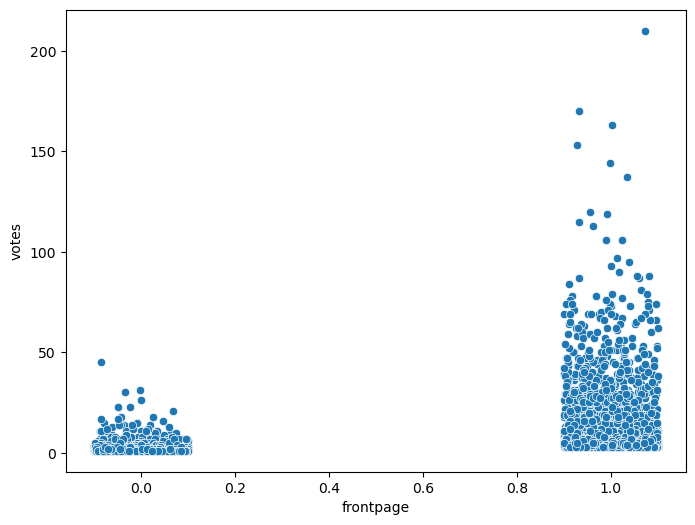

In [43]:
train_outlier=train[train.votes>500]
train_plot=train.drop(train_outlier.index)

jitter_strength = 0.1
jittered_frontpage = train_plot['frontpage'] + np.random.uniform(-jitter_strength, jitter_strength, size=train_plot.shape[0])

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=jittered_frontpage, y=train_plot['votes'])
plt.show()

In [44]:
## create a spark DataFrame out of our pandas DataFrame
spark_train = spark.createDataFrame(train)
spark_test = spark.createDataFrame(test)
#spark_df = spark_df.sample(withReplacement=False, fraction=0.1, seed=1)
## repartition the df (may make it easier to process)
spark_train = spark_train.repartition(4)
spark_test = spark_test.repartition(4)

In [45]:
## show contents of the DataFrame
spark_train.show()

+---------+--------------------+-----+--------+
|frontpage|               title|votes|comments|
+---------+--------------------+-----+--------+
|        0|Exposure to poor ...|    2|       0|
|        0|OpenSSF Warns of ...|    2|       0|
|        0|How do Spotify Co...|    1|       0|
|        0|FDA says 1 in 5 s...|    3|       0|
|        0|Sequoia commits t...|    2|       2|
|        0|Experimental obes...|    1|       0|
|        0|Dopamine Nation: ...|    1|       0|
|        1|New scanning elec...|    8|       0|
|        0|Show HN: Meeting ...|    1|       0|
|        0|NASA's Chandra Re...|    2|       0|
|        0|           500 Miles|    1|       0|
|        0|Anonymizing resea...|    1|       0|
|        0|Little Helper – A...|    1|       0|
|        0|Open Source's Fun...|    1|       0|
|        1|The Gift of Ambition|    3|       0|
|        1|What do you call ...|   26|       2|
|        0|Harnessing Geothe...|    2|       0|
|        0|Jerry Seinfeld’s ...|    1|  

In [46]:
## convert our variable of text into list of words
tokenizer = RegexTokenizer(inputCol="title", outputCol="title_words", pattern="\\W")

## adds a column of our tokenised words to df
spark_train_tokenised = tokenizer.transform(spark_train)

## show contents of the DF
spark_train_tokenised.select(['frontpage','title', 'title_words']).show(5)

+---------+--------------------+--------------------+
|frontpage|               title|         title_words|
+---------+--------------------+--------------------+
|        1|Unearthing APT44:...|[unearthing, apt4...|
|        1|Tesla's 2M car Au...|[tesla, s, 2m, ca...|
|        0|   The Pen, Mightier|[the, pen, mightier]|
|        0|How to Exploit a ...|[how, to, exploit...|
|        0|        Westward Ho!|      [westward, ho]|
+---------+--------------------+--------------------+
only showing top 5 rows



In [47]:
## stopwords remove to remove common, uninformative words
stopwords_remover = StopWordsRemover(inputCol="title_words", outputCol="f_title_words")

## adds a column of the filtered words to df
spark_train_stopwordless = stopwords_remover.transform(spark_train_tokenised)

In [48]:
## print the contents of the DF
spark_train_stopwordless.select(['frontpage','title', 'title_words', 'f_title_words']).show(5)

+---------+--------------------+--------------------+--------------------+
|frontpage|               title|         title_words|       f_title_words|
+---------+--------------------+--------------------+--------------------+
|        1|Unearthing APT44:...|[unearthing, apt4...|[unearthing, apt4...|
|        1|Tesla's 2M car Au...|[tesla, s, 2m, ca...|[tesla, 2m, car, ...|
|        0|   The Pen, Mightier|[the, pen, mightier]|     [pen, mightier]|
|        0|How to Exploit a ...|[how, to, exploit...|[exploit, buffer,...|
|        0|        Westward Ho!|      [westward, ho]|      [westward, ho]|
+---------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [49]:
## Calculate term frequency in each article
hashing_tf = HashingTF(inputCol="f_title_words",
                       outputCol="raw_features", 
                       numFeatures=256)

## adds raw tf features to the DF
featurized_data = hashing_tf.transform(spark_train_stopwordless)

In [50]:
## Inverse document frequency
idf = IDF(inputCol="raw_features", outputCol="title_features")

idf_vectorizer = idf.fit(featurized_data)

## converting text to vectors
rescaled_data = idf_vectorizer.transform(featurized_data)

## display the top 20 rows
rescaled_data.select('frontpage','title', 'title_words', 'f_title_words', "title_features").show()

+---------+--------------------+--------------------+--------------------+--------------------+
|frontpage|               title|         title_words|       f_title_words|      title_features|
+---------+--------------------+--------------------+--------------------+--------------------+
|        1|Unearthing APT44:...|[unearthing, apt4...|[unearthing, apt4...|(256,[63,96,121,1...|
|        1|Tesla's 2M car Au...|[tesla, s, 2m, ca...|[tesla, 2m, car, ...|(256,[35,59,73,15...|
|        0|   The Pen, Mightier|[the, pen, mightier]|     [pen, mightier]|(256,[63,186],[3....|
|        0|How to Exploit a ...|[how, to, exploit...|[exploit, buffer,...|(256,[44,105,197]...|
|        0|        Westward Ho!|      [westward, ho]|      [westward, ho]|(256,[22,249],[4....|
|        0|Show HN: Building...|[show, hn, buildi...|[show, hn, buildi...|(256,[14,60,110,1...|
|        1|Changes from Visa...|[changes, from, v...|[changes, visa, m...|(256,[3,79,88,89,...|
|        0|CSS Flags – Flags...|[css, fl

In [51]:
assembler = VectorAssembler(inputCols=['title_features', 'votes', 'comments'],outputCol="features")
rescaled_data = assembler.transform(rescaled_data)

In [52]:
#### TEST #### WITHOUT #### TEXT #### FEATURES ####

# assembler = VectorAssembler(inputCols=['votes', 'comments'],outputCol="features")
# rescaled_data = assembler.transform(rescaled_data)

In [53]:
## model object
lr = LogisticRegression(featuresCol='features',
                        labelCol='frontpage',
                        family="auto",
                        maxIter=50)

## train model with default parameters
lrModel = lr.fit(rescaled_data)

In [ ]:
# Test-set Accuracy is :  0.9821321961620465 with the text features
# Test-set Accuracy is :  0.9884550155625812 without the text features

## Model Pipeline

In [57]:
# pipeline staging area
tokenizer = RegexTokenizer(inputCol="title", outputCol="title_words", pattern="\\W")
stopwords_remover = StopWordsRemover(inputCol="title_words", outputCol="f_title_words")
hashing_tf = HashingTF(inputCol="f_title_words",
                       outputCol="raw_features", 
                       numFeatures=256)
idf = IDF(inputCol="raw_features", outputCol="title_features")
assembler = VectorAssembler(inputCols=['title_features', 'votes', 'comments'],outputCol="features")
lr = LogisticRegression(featuresCol='features',
                        labelCol='frontpage',
                        family="auto",
                        maxIter=50)

In [58]:
pipeline = Pipeline(stages=[tokenizer, stopwords_remover, hashing_tf, idf, assembler, lr])

In [59]:
model=pipeline.fit(spark_train)

In [60]:
model_path = "C:\\Users\\Dillon\\Desktop\\spark\\notebooks\\models"
model.write().overwrite().save(model_path)

In [61]:
pred_model = PipelineModel.load(model_path)

In [62]:
predictions = pred_model.transform(spark_test)

In [63]:
predictions.select("title", "votes", "comments", "probability", "prediction", "frontpage").show()

+--------------------+-----+--------+--------------------+----------+---------+
|               title|votes|comments|         probability|prediction|frontpage|
+--------------------+-----+--------+--------------------+----------+---------+
|Glitch on BepiCol...|    2|       0|[0.91989247679589...|       0.0|        0|
|Petflix, the Vide...|    2|       0|[0.97834281919763...|       0.0|        0|
|Reverse Engineeri...|    1|       0|[0.98335741258370...|       0.0|        0|
|  American Flag Sort|   16|       0|[1.00441332701935...|       1.0|        1|
|A Visit to id Sof...|    1|       0|[0.98063894842531...|       0.0|        0|
|Design Principles...|    2|       0|[0.93663699072590...|       0.0|        0|
|Mozilla commissio...|    1|       0|[0.98213224014309...|       0.0|        0|
|Littlejohn and th...|    1|       0|[0.97237696274965...|       0.0|        0|
|Party Like It's 1...|    1|       0|[0.95815858549980...|       0.0|        0|
|Video codec writt...|    2|       0|[0.

In [64]:
## to evalute model
evaluator = BinaryClassificationEvaluator(labelCol="frontpage")

## print test accuracy
print("Test-set Accuracy is : ", evaluator.evaluate(predictions))

Test-set Accuracy is :  0.9823342678100264
